LangGraph Chatbot Quickstart — Step-by-Step in a Notebook

In [2]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_anthropic


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Step 2: Set API Key for Claude (Anthropic)

In [1]:
%pip install -Uq python-dotenv

import os
from dotenv import load_dotenv

if os.path.exists('../.env'):
    load_dotenv('../.env')

Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# we will use Groq models to make this free to use. but we still need an API key
import os
import getpass

if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = "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"

Step 3: Define the Graph State

In [11]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# Define what kind of data the graph will carry
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Create a new state graph
graph_builder = StateGraph(State)

Step 4: Add a Chatbot Node

In [13]:
%pip install -U langchain-groq


   ---------------------------------------- 0.0/126.7 kB ? eta -:--:--
   --------- ----------------------------- 30.7/126.7 kB 660.6 kB/s eta 0:00:01
   -------------------------------------- - 122.9/126.7 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 126.7/126.7 kB 1.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
from langchain_groq import ChatGroq

# Use LLaMA 3 model via Groq
llm = ChatGroq(model="llama3-8b-8192")

# Node logic: respond to user input using the Groq LLM
def chatbot(state: State):
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

# Add node to graph
graph_builder.add_node("chatbot", chatbot)

Step 5: Define Graph Flow (Start ➡️ Chatbot ➡️ End)

In [15]:
# Connect nodes: from START to chatbot, and chatbot to END
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

Step 6: Compile the Graph

In [16]:
# Compile the graph into a runnable version
graph = graph_builder.compile()

Step 7: Visualize the Graph

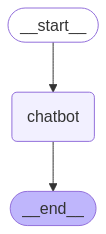

In [17]:
from IPython.display import Image, display

try:
    # You can install 'graphviz' to use this feature
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    print("Graph visualization not available (install missing dependencies).")


Step 8: Chat with Your LangGraph Chatbot

In [18]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

# Start chat loop
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        user_input = "What do you know about LangGraph?"
        print("User:", user_input)
        stream_graph_updates(user_input)
        break


Assistant: LangGraph is a tool that helps with natural language processing (NLP) tasks, particularly in the areas of language modeling, text classification, and named entity recognition. Here are some of the things that LangGraph can do:

1. **Language Modeling**: LangGraph can generate text based on a given prompt or input, and it can also predict the next word or character in a sequence given the context.
2. **Text Classification**: LangGraph can classify text into categories or labels based on its content, such as spam vs. non-spam emails, positive vs. negative reviews, or news articles vs. blog posts.
3. **Named Entity Recognition (NER)**: LangGraph can identify and extract specific entities such as names, locations, organizations, and dates from unstructured text.
4. **Part-of-Speech (POS) Tagging**: LangGraph can identify the parts of speech (such as nouns, verbs, adjectives, etc.) in a given text.
5. **Dependency Parsing**: LangGraph can analyze the grammatical structure of a se